# Assignment 1  
**Name:** Arnob Aich Anurag  
**ID:** 23-51390-1  

**Setup**

In [180]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from collections import Counter

In [181]:
Dataset_dir = 'animals'
Categories = []
for c in os.listdir(Dataset_dir):
    Categories.append(c)
print(Categories)

['cats', 'dogs', 'panda']


In [ ]:
IMG_SIZE = 32
NUM_IMAGES = 300

all_data = []
for category in Categories:
    path = os.path.join(Dataset_dir, category)
    class_index = Categories.index(category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        all_data.append((img_path, class_index, img_name))

random.shuffle(all_data)
selected_data = all_data[:NUM_IMAGES]

In [183]:
features = []
labels = []
display_data = []

for img_path, class_index, img_name in selected_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        features.append(img.flatten() / 255.0)
        labels.append(class_index)
        display_data.append((img, class_index, img_name))
    except:
        continue

features = np.array(features)
labels = np.array(labels)

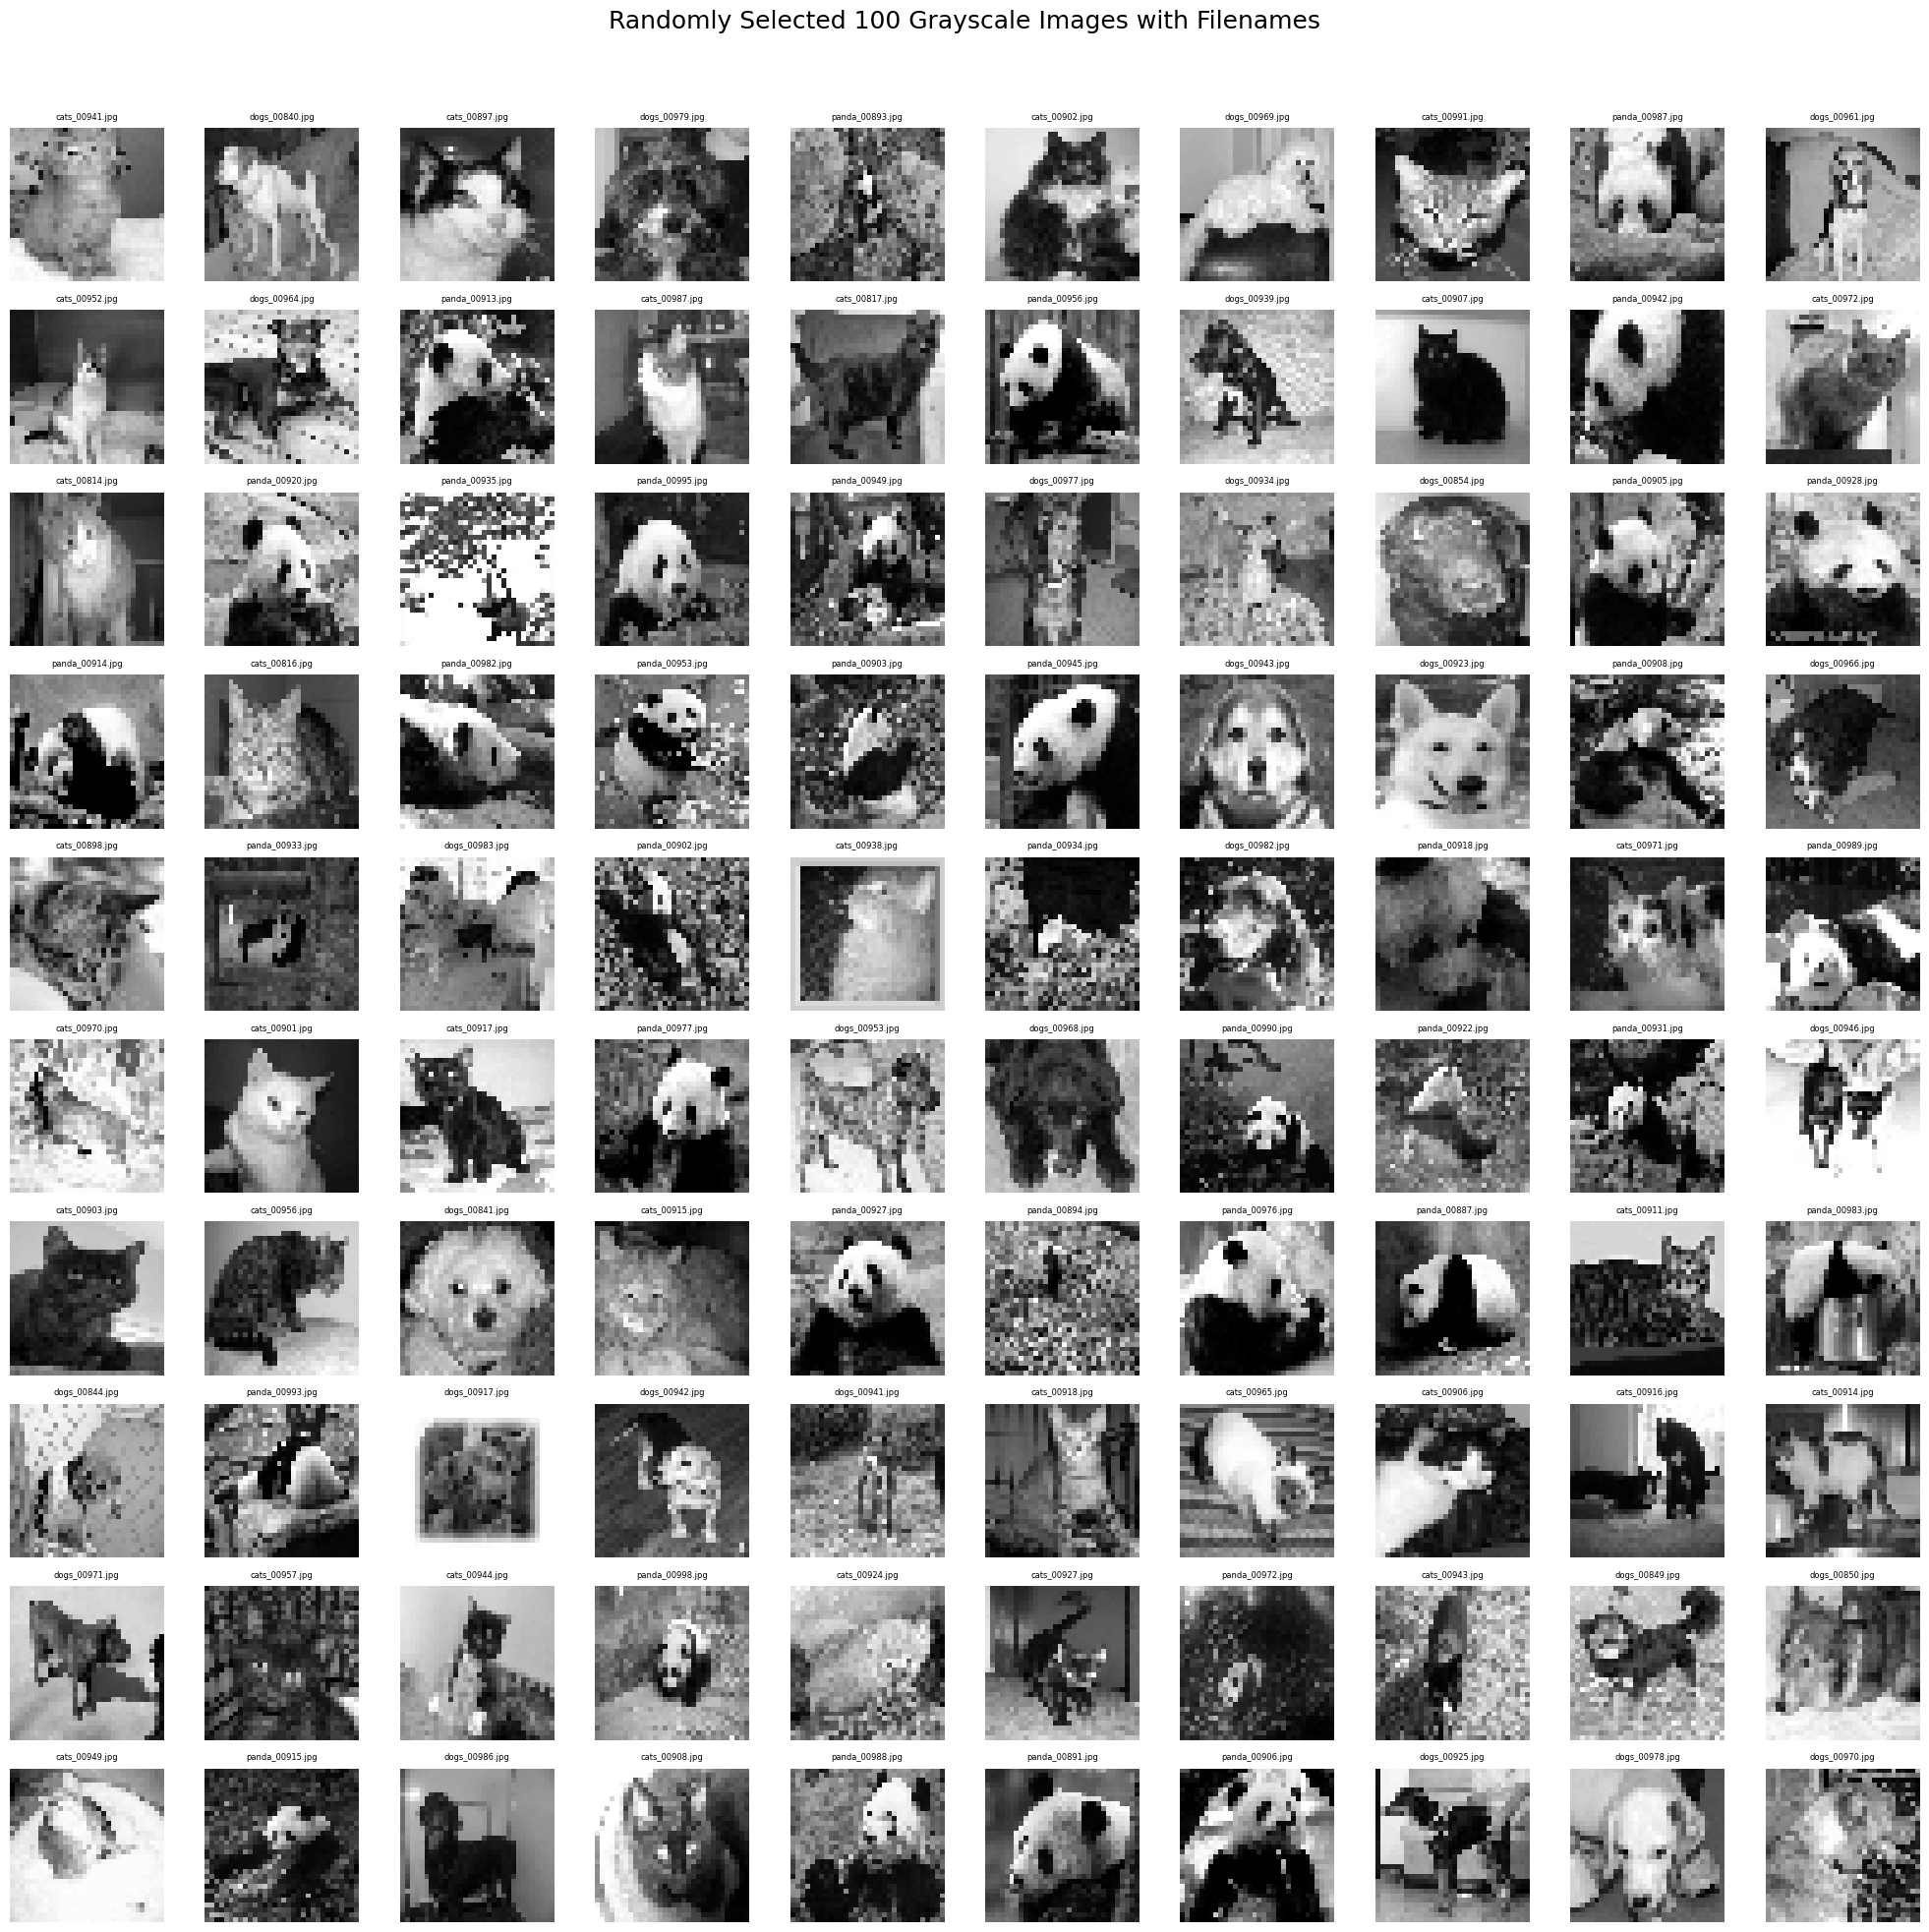

Total images processed: 300


In [ ]:

plt.figure(figsize=(20, 20))
for i in range(min(len(display_data), 100)): 
    img, _, name = display_data[i]
    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(name[:100], fontsize=6)  
    plt.axis('off')

plt.suptitle("Randomly Selected 100 Grayscale Images with Filenames", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

print("Total images processed:", len(features))

**Training**

In [ ]:


def manhattan_distance(vec1, vec2):
   
    return np.sum(np.abs(vec1 - vec2))


def euclidean_distance(vec1, vec2):
   
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

As you can see that  it zips features and labels into a single list and shuffles them to randomize the order. It then divides the data into 5 equally sized folds for cross-validation (here we have 300 images.So each fold will have 60). If the total number of items isn't evenly divisible by 5, the remaining items are distributed one by one into the initial folds. To confirm the split, it prints the size of each fold.

In [ ]:

data = list(zip(features, labels))  
random.shuffle(data)
fold_size = len(data) // 5
folds = [data[i * fold_size : (i + 1) * fold_size] for i in range(5)]
remainder = len(data) % 5
for i in range(remainder):
    folds[i].append(data[5 * fold_size + i])


for i, fold in enumerate(folds):
    print(f"Fold {i+1} size:", len(fold))

Fold 1 size: 60
Fold 2 size: 60
Fold 3 size: 60
Fold 4 size: 60
Fold 5 size: 60


After shuffling the data, the code splits it into 5 stratified folds for cross-validation, allocating leftover samples sequentially to ensure fairness. Fold sizes are then printed to verify proper partitioning.

In [ ]:
def knn_predict(X_train, y_train, x_test, k=7, distance_type='l2'):
    distances = []
    for i in range(len(X_train)):
        if distance_type == 'l1':
            dist = manhattan_distance(X_train[i], x_test)
        else:
            dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))
    

    distances.sort(key=lambda x: x[0])

    k_labels = [label for _, label in distances[:k]]

    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]

In [ ]:
def run_knn_cross_validation(folds, k_values, distance_type='l2'):
    fold_wise_accuracies = []

    for fold_index in range(5):
        
        validation_data = folds[fold_index]
        training_data = []
        for i in range(5):
            if i != fold_index:
                training_data.extend(folds[i])
        X_train = np.array([item[0] for item in training_data])
        y_train = np.array([item[1] for item in training_data])
        X_val = np.array([item[0] for item in validation_data])
        y_val = np.array([item[1] for item in validation_data])

        fold_accuracies = []

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            accuracy = (correct / len(X_val)) * 100
            fold_accuracies.append(accuracy)

        fold_wise_accuracies.append(fold_accuracies)

    avg_accuracies = np.mean(fold_wise_accuracies, axis=0)
    return fold_wise_accuracies, avg_accuracies

The dataset is evaluated using K-Nearest Neighbors (KNN) with 5-fold cross-validation. In each iteration, one fold serves as the validation set while the other four form the training set. Features and labels are separated for both sets, and the model tests K values from 1 to 20. For each K, distances (Manhattan/L1 or Euclidean/L2) between validation and training samples are computed, sorted, and used to predict labels via majority voting among the K closest neighbors. Accuracy per K is recorded for each fold, with results aggregated separately for both distance metrics.

In [189]:
def evaluate_knn(distance_func, label=""):
    k_best = 3
    y_true_all = []
    y_pred_all = []

    for fold_index in range(5):
        validation_set = folds[fold_index]
        training_set = [item for i, fold in enumerate(folds) if i != fold_index for item in fold]

        for val_img, val_label in validation_set:
            distances = [(distance_func(val_img, train_img), train_label)
                         for train_img, train_label in training_set]
            pred = knn_predict(distances, k_best)
            y_true_all.append(val_label)
            y_pred_all.append(pred)

    print(f"\nResults for {label}:")

The graphs show KNN accuracy using Manhattan (L1) and Euclidean (L2) distances across different K values and data folds. Accuracy generally increases with K to a peak, then plateaus or declines. Comparing the "Average Accuracy" lines, Manhattan (L1) distance consistently yields higher overall classification accuracy than Euclidean (L2) distance for this dataset.

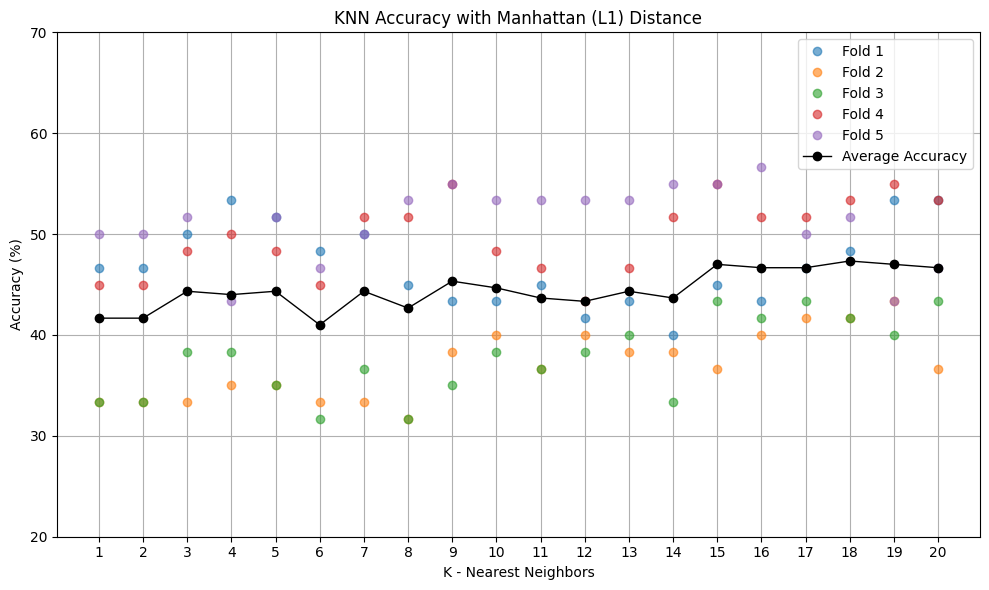

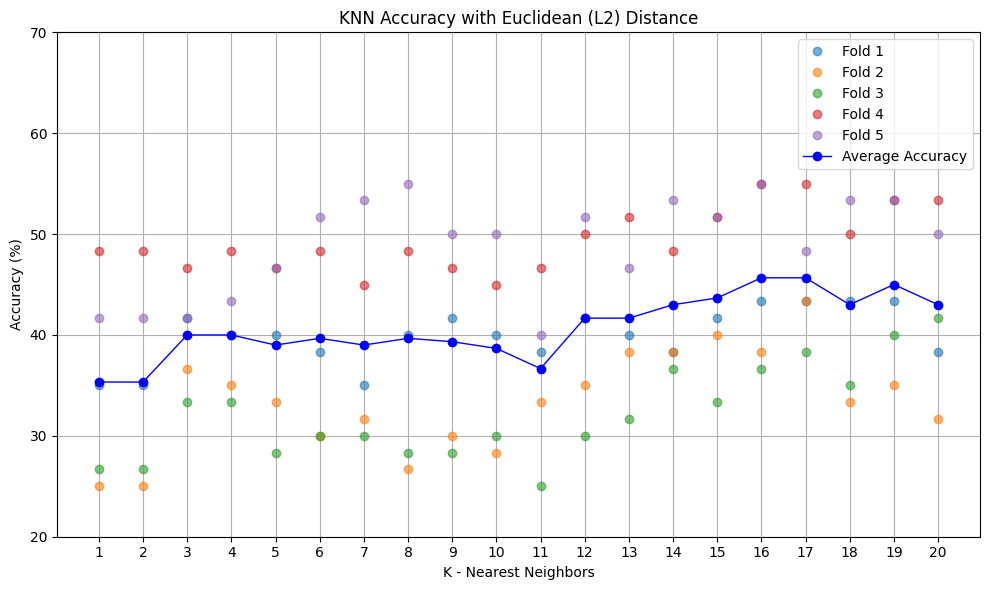

In [ ]:
K_values = np.arange(1, 21)


fold_acc_l1, avg_acc_l1 = run_knn_cross_validation(folds, K_values, distance_type='l1')
fold_acc_l2, avg_acc_l2 = run_knn_cross_validation(folds, K_values, distance_type='l2')


def plot_knn_accuracy(K, fold_accuracies, avg_accuracies, title, color):
    plt.figure(figsize=(10, 6))
    
    for i, acc in enumerate(fold_accuracies):
        plt.plot(K, acc, 'o', label=f'Fold {i+1}', alpha=0.6)
    
    plt.plot(K, avg_accuracies, 'o-', color=color, label='Average Accuracy', linewidth=1)
    
    plt.xlabel("K - Nearest Neighbors")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(1, 21, 1))
    plt.ylim(20, 70)
    plt.tight_layout()
    plt.show()

plot_knn_accuracy(K_values, fold_acc_l1, avg_acc_l1, "KNN Accuracy with Manhattan (L1) Distance", color='black')
plot_knn_accuracy(K_values, fold_acc_l2, avg_acc_l2, "KNN Accuracy with Euclidean (L2) Distance", color='blue')

In [ ]:

print("Average Accuracy for Manhattan (L1) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l1[i]:.2f}%")

print("\nAverage Accuracy for Euclidean (L2) Distance:")
for i in range(len(K_values)):
    print(f"K = {K_values[i]:2d} : {avg_acc_l2[i]:.2f}%")

Average Accuracy for Manhattan (L1) Distance:
K =  1 : 41.67%
K =  2 : 41.67%
K =  3 : 44.33%
K =  4 : 44.00%
K =  5 : 44.33%
K =  6 : 41.00%
K =  7 : 44.33%
K =  8 : 42.67%
K =  9 : 45.33%
K = 10 : 44.67%
K = 11 : 43.67%
K = 12 : 43.33%
K = 13 : 44.33%
K = 14 : 43.67%
K = 15 : 47.00%
K = 16 : 46.67%
K = 17 : 46.67%
K = 18 : 47.33%
K = 19 : 47.00%
K = 20 : 46.67%

Average Accuracy for Euclidean (L2) Distance:
K =  1 : 35.33%
K =  2 : 35.33%
K =  3 : 40.00%
K =  4 : 40.00%
K =  5 : 39.00%
K =  6 : 39.67%
K =  7 : 39.00%
K =  8 : 39.67%
K =  9 : 39.33%
K = 10 : 38.67%
K = 11 : 36.67%
K = 12 : 41.67%
K = 13 : 41.67%
K = 14 : 43.00%
K = 15 : 43.67%
K = 16 : 45.67%
K = 17 : 45.67%
K = 18 : 43.00%
K = 19 : 45.00%
K = 20 : 43.00%


In [ ]:

data = []
for i in range(len(features)):
    data.append([features[i], labels[i]])


random.shuffle(data)

split = int(0.8 * len(data))
train = data[:split]
test = data[split:]

train_x = []
train_y = []
for item in train:
    train_x.append(item[0])
    train_y.append(item[1])


test_x = []
test_y = []
for item in test:
    test_x.append(item[0])
    test_y.append(item[1])

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [193]:
def get_accuracy(train_x, train_y, test_x, test_y, k=3, dist_type='l2'):
    correct = 0
    for i in range(len(test_x)):
        pred = knn_predict(train_x, train_y, test_x[i], k=k, distance_type=dist_type)
        if pred == test_y[i]:
            correct += 1
    return (correct / len(test_y)) * 100

In [ ]:
k = 5  


train_acc_l1 = get_accuracy(train_x, train_y, train_x, train_y, k, 'l1')
test_acc_l1 = get_accuracy(train_x, train_y, test_x, test_y, k, 'l1')


train_acc_l2 = get_accuracy(train_x, train_y, train_x, train_y, k, 'l2')
test_acc_l2 = get_accuracy(train_x, train_y, test_x, test_y, k, 'l2')


print(f"L1 - Train Accuracy: {train_acc_l1:.2f}%")
print(f"L1 - Test Accuracy : {test_acc_l1:.2f}%")
print("---")
print(f"L2 - Train Accuracy: {train_acc_l2:.2f}%")
print(f"L2 - Test Accuracy : {test_acc_l2:.2f}%")

L1 - Train Accuracy: 67.50%
L1 - Test Accuracy : 50.00%
---
L2 - Train Accuracy: 62.08%
L2 - Test Accuracy : 50.00%


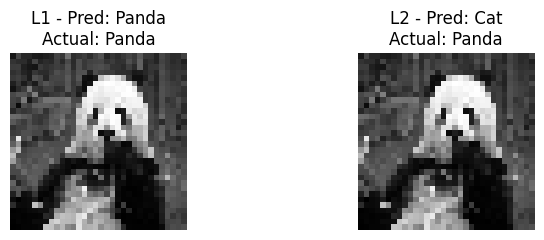

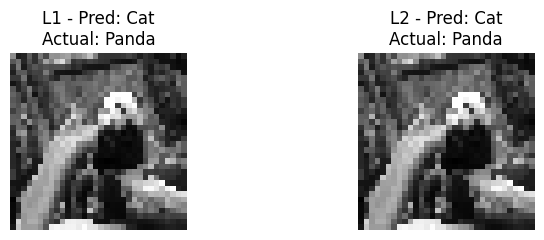

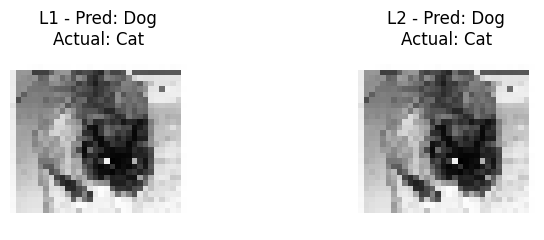

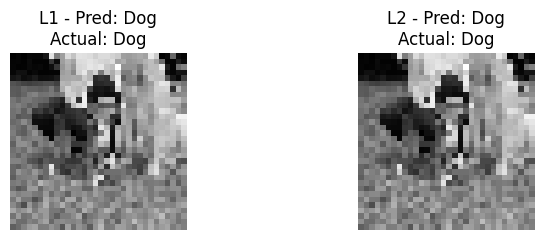

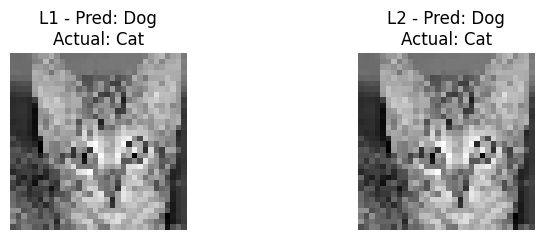

In [ ]:

split_index = int(0.8 * len(features))
X_train, X_test = features[:split_index], features[split_index:]
y_train, y_test = labels[:split_index], labels[split_index:]


class_names = ['Cat', 'Dog', 'Panda']


def show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7):
    for i in range(5):
        img = X_test[i].reshape(32, 32)
        
        pred_l1 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l1')
        pred_l2 = knn_predict(X_train, y_train, X_test[i], k=k, distance_type='l2')
        
        # Plot side-by-side
        plt.figure(figsize=(8, 2.5))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"L1 - Pred: {class_names[pred_l1]}\nActual: {class_names[y_test[i]]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img, cmap='gray')
        plt.title(f"L2 - Pred: {class_names[pred_l2]}\nActual: {class_names[y_test[i]]}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

show_top_5_predictions(X_train, y_train, X_test, y_test, class_names, k=7)

**Description**


**What I Did**
I built a KNN (K-Nearest Neighbors) model and tested how well it worked by trying different numbers of neighbors (K values from 1 to 10). To get reliable results, I used 5-fold cross-validation, which means I split my data into 5 parts and tested the model 5 times, making sure each image got tested at least once.

I compared two ways of measuring distance between images:
- Manhattan distance: adds up the absolute differences between pixels
- Euclidean distance: uses the square root of squared pixel differences

For each distance method, I calculated the average accuracy across all 5 tests and created graphs to see how accuracy changed with different K values.


My dataset was quite small with only 300 images, and I had to shrink all images to 32×32 pixels, which likely lost important details. I also used raw pixel values without extracting meaningful features like edges or textures that might help with classification.

KNN has some inherent drawbacks: it's slow because it has to calculate distances to every training image for each prediction, and it can be fooled by irrelevant features or differences in data scaling.


To improve my model, I could use a larger dataset and extract better features from the images before classification. Techniques like Principal Component Analysis (PCA) could help reduce unnecessary complexity, while specialized data structures like KD-Trees could speed up the distance calculations.

I could also test my approach on more challenging datasets or compare KNN against other machine learning algorithms to see which works best for my specific task.


My KNN implementation successfully demonstrated how the choice of K value and distance metric affects classification performance, but there's plenty of room for improvement with more data and better feature engineering.